In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn import svm
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import cv2
from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from keras.datasets import cifar10
import tensorflow as t

2023-06-25 22:57:59.367644: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 22:57:59.436830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 22:58:00.128816: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 22:58:00.138131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 22:58:05.938814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Sobel

In [4]:
img = cv2.imread('cat.jpg')

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)

In [7]:
theta = np.arctan2(sobely, sobelx)
theta = np.rad2deg(theta)

In [8]:
cv2.imshow('Original', img)
cv2.imshow('Sobel', sobel.astype(np.uint8))

cv2.waitKey(0)
cv2.destroyAllWindows()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/konstantin/.local/lib/python3.11/site-packages/cv2/qt/plugins"


### HOG

In [9]:
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

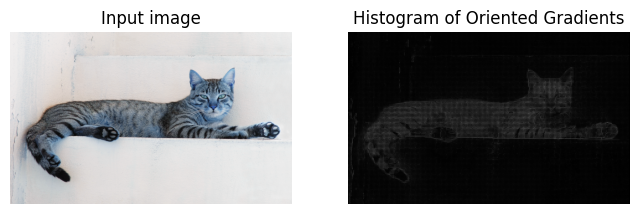

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### CIFAR-10, HOG

In [11]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 41s 0us/step


/home/konstantin/.local/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


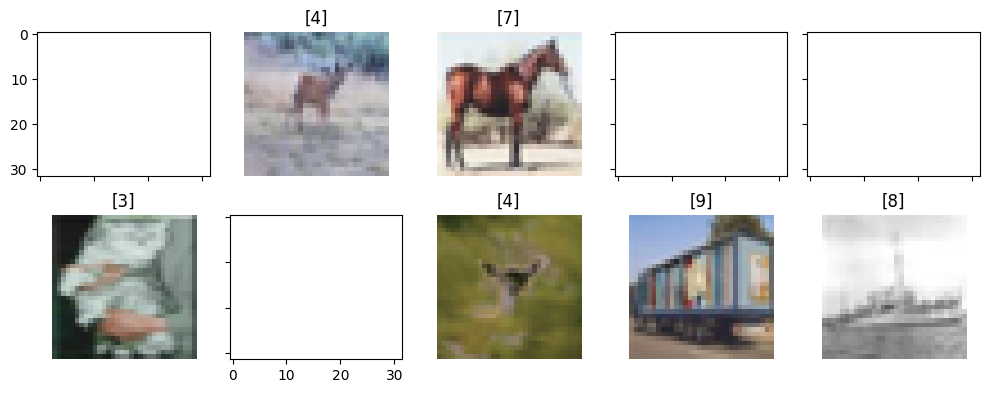

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()
for i in np.random.choice(X_train.shape[0], 10):
    image = X_train[i]
    ax[i%10].imshow(image)
    ax[i%10].set_title(y_train[i])
    ax[i%10].axis('off')
plt.tight_layout()
plt.show()

In [13]:
X_train_hog = []
for i in range(X_train.shape[0]):
    fd, hog_image = hog(X_train[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    X_train_hog.append(fd)

X_test_hog = []
for i in range(X_test.shape[0]):
    fd, hog_image = hog(X_test[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    X_test_hog.append(fd)

In [17]:
X_train_hog = np.array(X_train_hog)
X_test_hog = np.array(X_test_hog)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [18]:
X_train_hog, X_val_hog, y_train, y_val = train_test_split(X_train_hog, y_train, test_size=0.2, random_state=42)

In [19]:
clf = LinearSVC(random_state=42)
clf.fit(X_train_hog, y_train)
y_pred = clf.predict(X_val_hog)

In [20]:
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='macro')
rec = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

Accuracy: 0.4305
Precision: 0.4242170407040341
Recall: 0.4314083085070136
F1-Score: 0.4197684611264604


### SIFT

In [21]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

sift = cv2.SIFT_create()
descriptors = []

for i in np.arange(x_train.shape[0]):
    _, imgDesc = sift.detectAndCompute(x_train[i], None)
    if imgDesc is not None:
        for j in np.arange(imgDesc.shape[0]):
            descriptors.append(imgDesc[j])

descriptors = np.array(descriptors)

kmeans = KMeans(n_clusters=10).fit(descriptors)

train_hist_X = []
train_hist_Y = []

for i in np.arange(x_train.shape[0]):
    _, imgDesc = sift.detectAndCompute(x_train[i], None)
    if imgDesc is not None:
        kcent = kmeans.predict(imgDesc)
        hist, _ = np.histogram(kcent, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)
        train_hist_X.append(hist)
        train_hist_Y.append(y_train[i])

train_hist_X = np.array(train_hist_X).reshape((-1, 10))
train_hist_Y = np.array(train_hist_Y).reshape((-1,))


modSVM = SVC()
modSVM.fit(train_hist_X, train_hist_Y.reshape((-1,)))

conf_matrix_test = np.zeros((10, 10))

preds = []
labels = []
for i in np.arange(x_test.shape[0]):
    _, imgDesc = sift.detectAndCompute(x_test[i], None)
    if imgDesc is not None:
        kcent = kmeans.predict(imgDesc)
        hist, _ = np.histogram(kcent, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)
        ret = modSVM.predict(hist.reshape((1, -1)))[0]
        preds.append(ret)
        labels.append(y_test[i, 0])
        real = y_test[i, 0]
        conf_matrix_test[real, ret] = conf_matrix_test[real, ret] + 1

print("accuracy is {0}".format(accuracy_score(labels, preds)))

/home/romario/anaconda3/envs/tensorflow_gpu/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


accuracy is 0.2180232558139535


HOG дає кращі результати